In [ ]:
# ..... run MN on samples at metacell level from integrated data ..... #

In [2]:
library(SingleCellExperiment)
library(MetaNeighbor)
library(Seurat)

In [92]:
# load data
currstage = 'stage32'
sc1 = readRDS(paste0(currstage, '_integrated_cca.rds'))
dim(sc1@meta.data)

df1 = read.delim(paste0(currstage, '_metacell.csv'), sep = ',')
sc1$celltype = df1$metacell[match(rownames(sc1@meta.data), df1$barcode)]

df2 = read.delim(paste0(currstage, '_cluster_from_metacell_MN.csv'), sep = ',')
sc1$celltype2 = df2$cluster[match(sc1$celltype, df2$metacell)]
sc1$celltype3 = df2$cluster_mn[match(sc1$celltype, df2$metacell)]

sc1$stage <- sc1$orig.ident
sc1 <- sc1[,!is.na(sc1$celltype)]

# get metadata
cols = c('dataset', 'stage', 'celltype', 'celltype2', 'celltype3')
mtd1 = sc1@meta.data[,cols]

[1] 21401    28

In [93]:
# make SCE object
sce = SingleCellExperiment(list(counts = sc1@assays$RNA@counts),
                           colData = DataFrame(mtd1))
sce

class: SingleCellExperiment 
dim: 17007 19448 
metadata(0):
assays(1): counts
rownames(17007): SPRY2 PCDH20 ... ENSGALG00010000495 ENSGALG00010000377
rowData names(0):
colnames(19448): stage32_sample5_AAACCCACATACTGTG-1
  stage32_sample5_AAACCCACATCCTTGC-1 ...
  stage32_sample12_TTTGTTGGTAGACGGT-1
  stage32_sample12_TTTGTTGGTGCTCGTG-1
colData names(4): dataset stage celltype celltype2
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [94]:
options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$dataset)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

Time difference of 7.592687 secs

[1] 3772

In [95]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$dataset, 
    cell_type = sce$celltype2, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$dataset, 
    cell_type = sce$celltype2, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

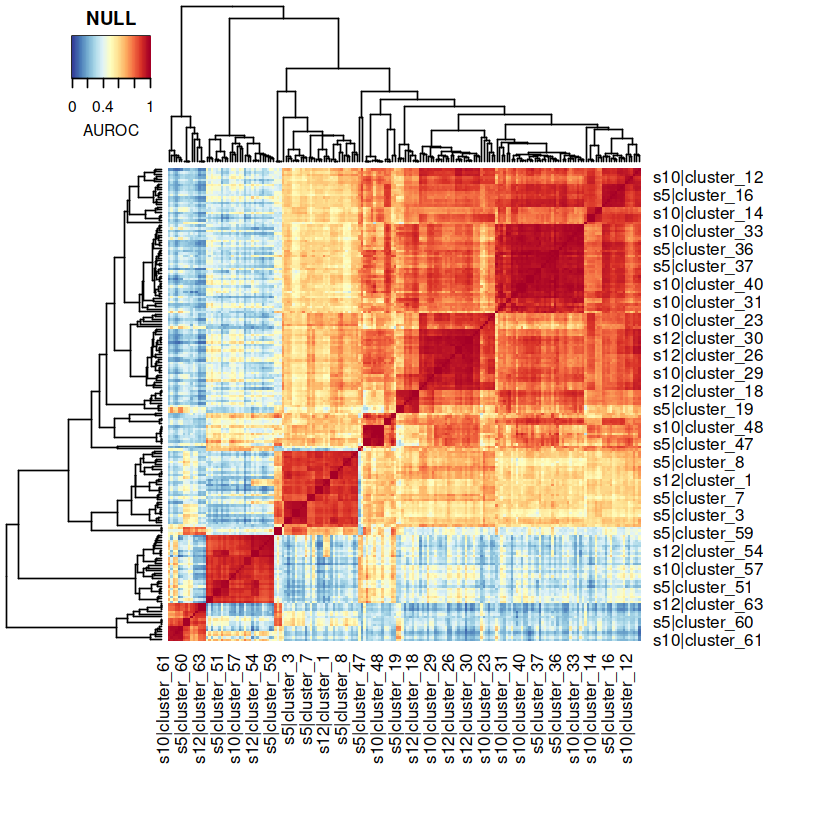

In [96]:
# png(paste0('aa-stage32_cca_MN.png'), width = 15, height = 15, res = 300, units = 'in')
plotHeatmap(aurocsall, margins = c(10,10))
# dev.off()

In [97]:
topdf = topHits(aurocsall, dat = sce, study_id = sce$dataset, 
                cell_type = sce$celltype2, threshold = 0.9)
dim(topdf)
tail(topdf)

[1] 130   4

Study_ID|Celltype_1 Study_ID|Celltype_2 Mean_AUROC Match_type
125 s10|cluster_57      s12|cluster_57      0.94       Above_0.9 
126 s12|cluster_23      s10|cluster_21      0.94       Above_0.9 
127 s10|cluster_57      s5|cluster_57       0.94       Above_0.9 
128 s10|cluster_21      s12|cluster_21      0.92       Above_0.9 
129 s5|cluster_64       s12|cluster_64      0.91       Above_0.9 
130 s12|cluster_21      s5|cluster_21       0.91       Above_0.9

In [98]:
# save
# save(aurocsall, aurocs1v1, topdf, file = paste0(currstage, '_metacell_MN_scores.Rdata'))

# write.table(topdf, file = paste0(currstage, '_merge_cluster.csv'), sep = ',', row.names = F, col.names = T, quote = F)

# write.table(topdf, file = paste0(currstage, '_merge_cluster2.csv'), sep = ',', row.names = F, col.names = T, quote = F)